# Financial Fraud Dataset - Basic Pipeline 

Analyze a synthetic bank transaction dataset to explore strategies for detecting the maximum number of fraudulent transactions while reducing false positives.

## Dataset Overview
### Brief descrption of the columns in this dataset: 
- **Step:** A unit of time that represents hours in the dataset. Think of this as the timestamp of the transaction (e.g. hour 1, hour 2, … hour 534, …) 
- **Type:** The type of transaction 
- **Amount:** The amount of money transferred 
- **NameOrig:** The origin account name
- **OldBalanceOrg:** The origin accounts balance before the transaction 
- **NewBalanceOrg:** The origin accounts balance after the transaction 
- **NameDest:** The destination account name 
- **OldbalanceDest:** The destination accounts balance before the transaction
- **NewbalanceDest:** The destination accounts balance after the transaction 
- **IsFlaggedFraud:** A “naive” model that simply flags a transaction as fraudulent if it is greater than 200,000 (note that this currency is not USD) 
- **IsFraud:** Was this simulated transaction actually fraudulent? In this case, we consider “fraud” to be a malicious transaction that aimed to transfer funds out of a victim’s bank account before the account owner could secure their information. 


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from mpl_toolkits.mplot3d import Axes3D


# Define correct column names for the dataset
correct_column_names = ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']
file_path = '/Users/sa3/Desktop/Financial Fraud Detection/Data/Raw Data.csv'

# Importing the data with the correct column names
df = pd.read_csv(file_path, names=correct_column_names, header=0)

# Displaying the first few rows of the data
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [33]:
df.shape

(6362620, 11)

In [34]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [35]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [36]:
# Checking the distribution of the target variable
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [37]:
# Checking the distribution of the target variable
df['isFlaggedFraud'].value_counts()


isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [38]:
# Checking the distribution of the type variable
df['type'].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

## Exploratory Data Analysis (EDA):
- Perform univariate, bivariate, and multivariate analysis.
- Generate relevant graphs to formulate hypotheses.
- Explore relationships between predictors and target variable.

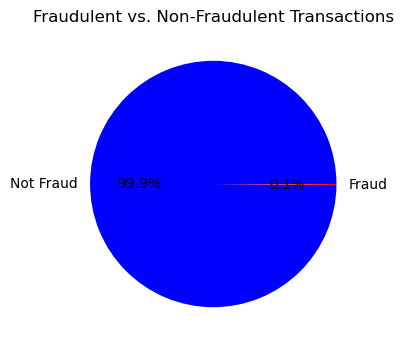

In [39]:
# Visualizing class distribution
plt.figure(figsize=(6, 4))
df['isFraud'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['blue', 'red'], labels=['Not Fraud', 'Fraud'])
plt.title('Fraudulent vs. Non-Fraudulent Transactions')
plt.ylabel('')
plt.show()

- 99.9% of transactions are Not Fraud, in blue.
- Only 0.1% of transactions are Fraud, in white.

### Univariate Analysis - Bar Graph & Pie Chart

In [40]:
#Transaction types
transaction_types = df['type']

# Transcation types distribution
transaction_type_distribution = transaction_types.value_counts()

print(f"Transaction Types Distribution: {transaction_type_distribution}")

Transaction Types Distribution: type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64


/var/folders/z4/2rstd0cd6mbfdq_6f5c_3m_r0000gn/T/ipykernel_31170/3028587654.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='type', palette='viridis')


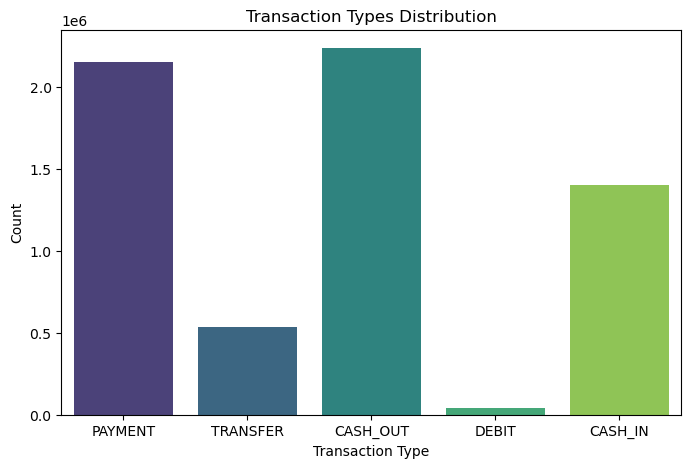

In [41]:
# Bar plot for transaction types
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='type', palette='viridis')
plt.title('Transaction Types Distribution')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()

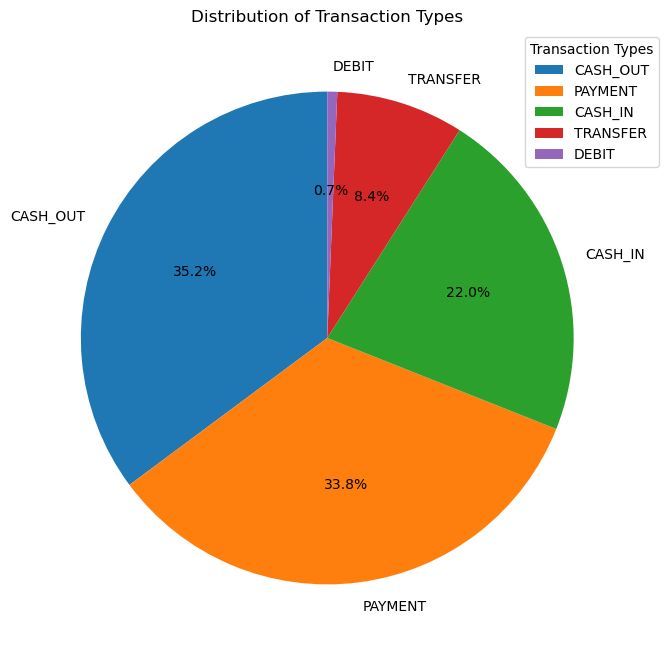

In [42]:
transaction_counts = df['type'].value_counts()
# pie chart
plt.figure(figsize=(8, 8)) 
wedges, texts, autotexts = plt.pie(transaction_counts, autopct='%1.1f%%', startangle=90, labels=transaction_counts.index)
plt.title('Distribution of Transaction Types')
plt.ylabel('')
plt.legend(wedges, transaction_counts.index, title='Transaction Types', loc='upper right', bbox_to_anchor=(1.05,1))
plt.show()

#### CASH_OUT and PAYMENT transactions are the most common
- CASH_OUT transactions have the highest count, meaning most transactions involve withdrawing money from an account.
- PAYMENT transactions are also very frequent, likely representing routine transactions like bills or purchases.

#### TRANSFER transactions occur less frequently
- These transactions involve sending money from one account to another. They are notably fewer compared to CASH_OUT and PAYMENT transactions.

#### DEBIT transactions are extremely rare
- This suggests that direct debits (e.g., automated payments) are not as commonly recorded in this dataset.

#### CASH_IN transactions happen frequently but not as much as CASH_OUT
- This suggests that users deposit money into their accounts, but withdrawing (CASH_OUT) is more common.

This means fraudulent transactions mainly occur in TRANSFER and CASH_OUT transactions.
PAYMENT and CASH_IN transactions rarely involve fraud.
This supports the decision to focus on TRANSFER and CASH_OUT transactions when building a fraud detection model.

### Bivariate Analysis - Pairplot & Scatter Plot

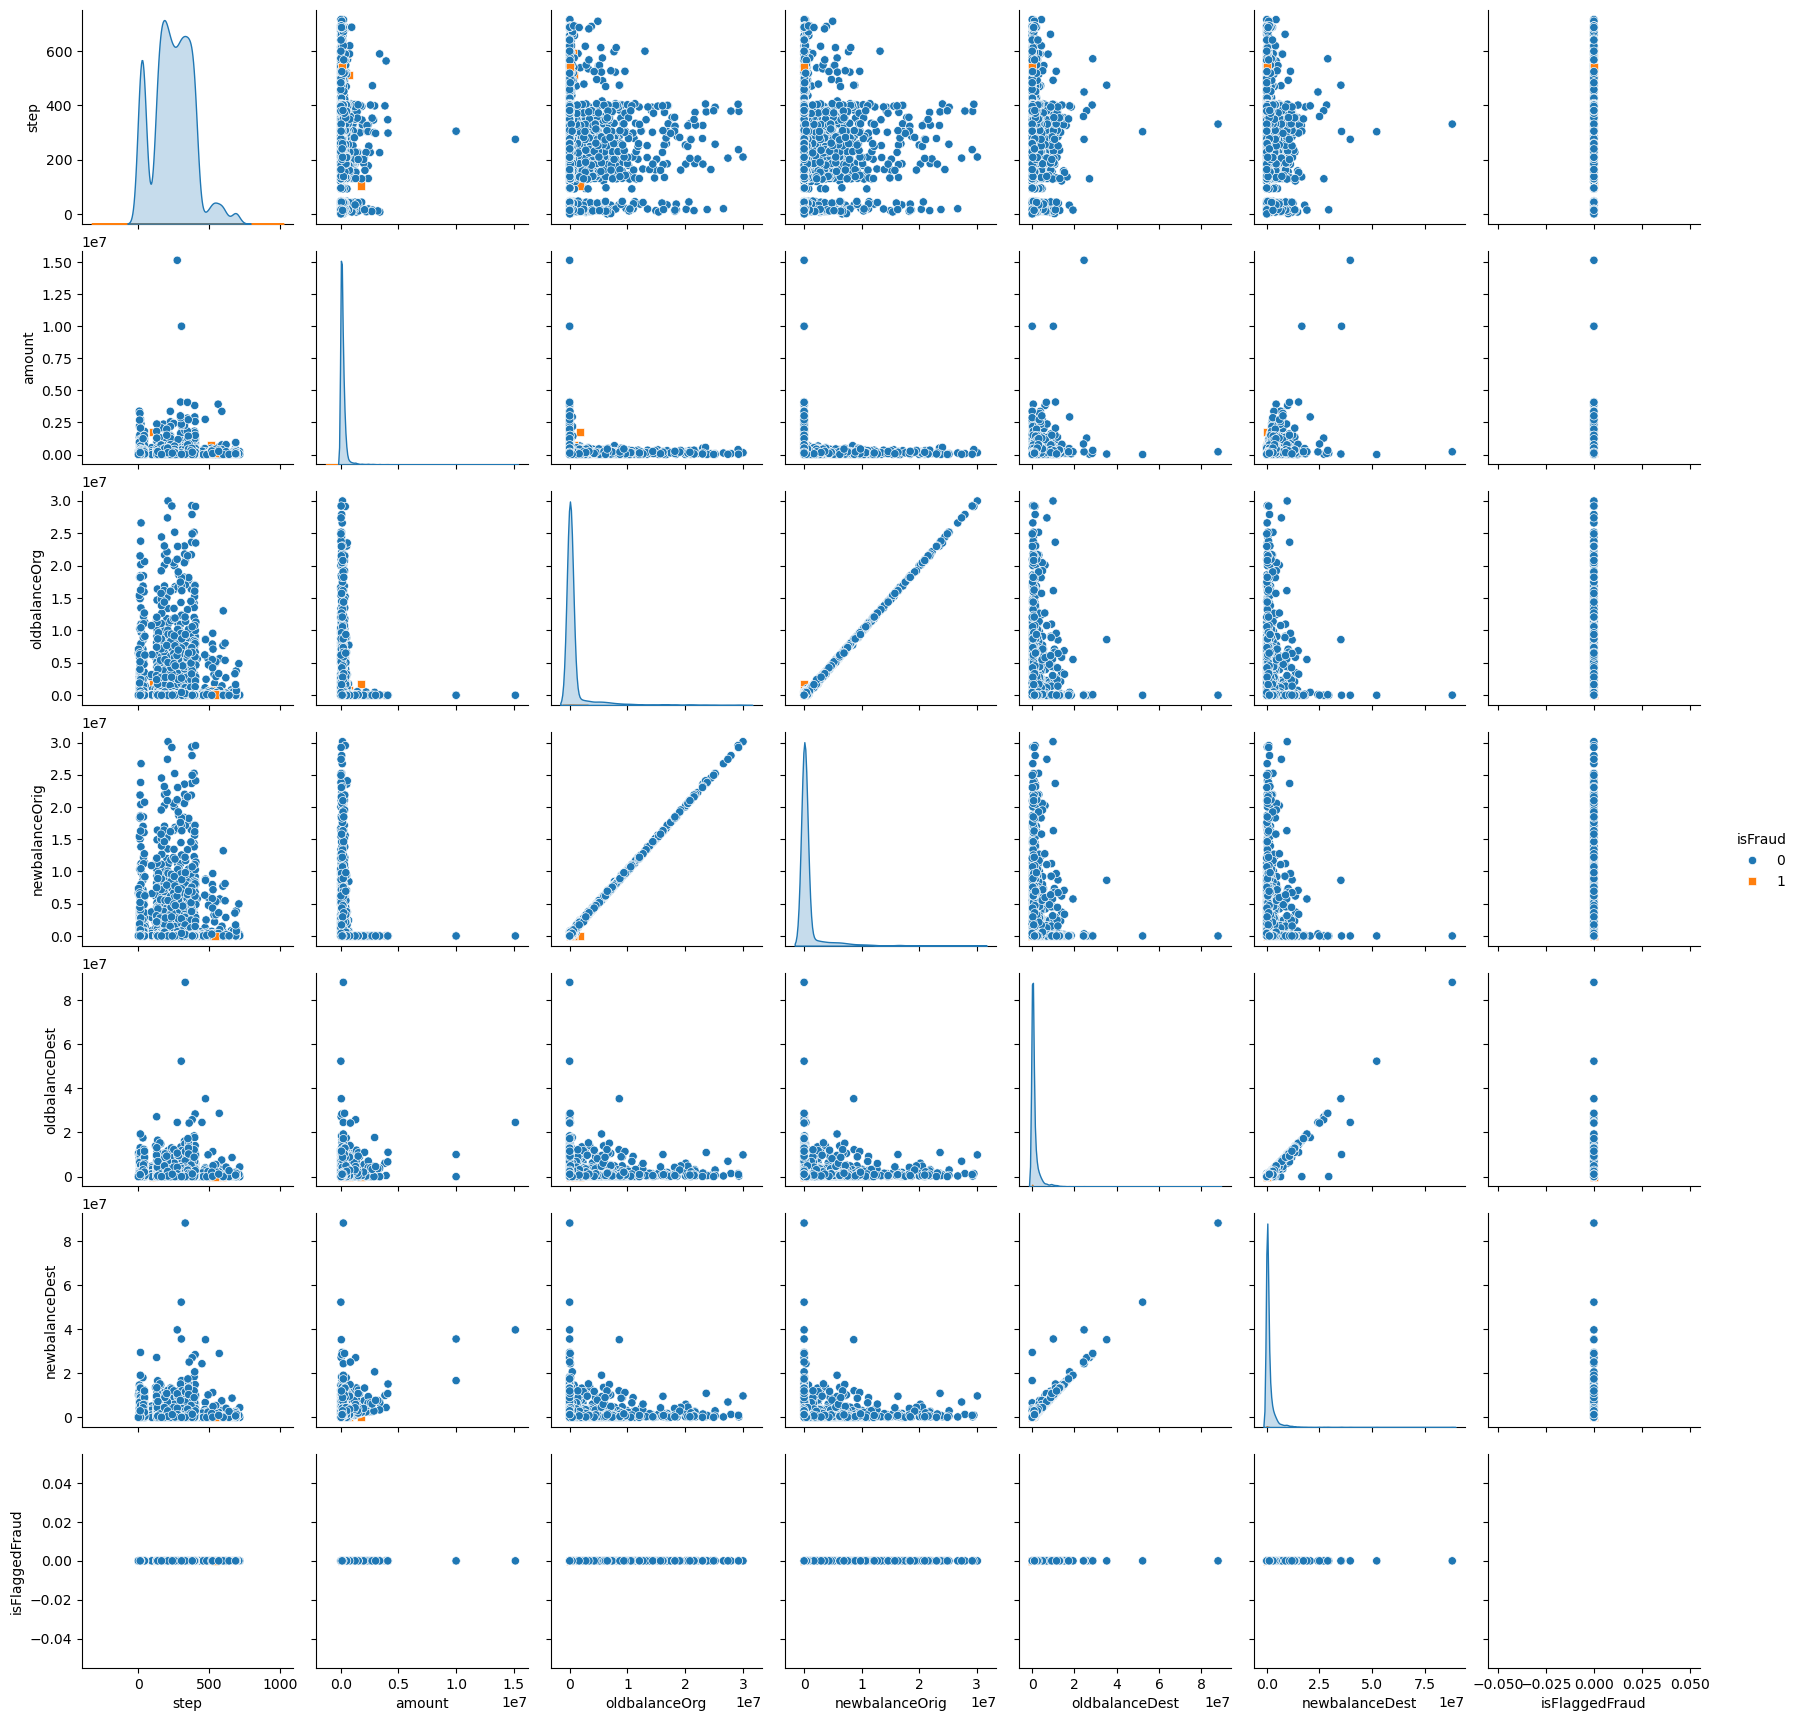

In [43]:
## Bivariate Analysis - Pairplot
sns.pairplot(df.sample(5000), hue='isFraud', diag_kind='kde', markers=['o', 's'])
plt.show()

- This pair plot visualization explores the relationships between multiple numerical features in the dataset.
- Some features, like amount, oldbalanceOrg, and newbalanceOrig, have extreme right-skewed distributions, meaning most transactions are small while a few are extremely large.
- Fraudulent transactions (orange) seem to cluster differently from non-fraudulent ones (blue), especially in balance-related features.
- This indicates that fraudulent transactions may have distinct balance change patterns, which can be useful for model training.

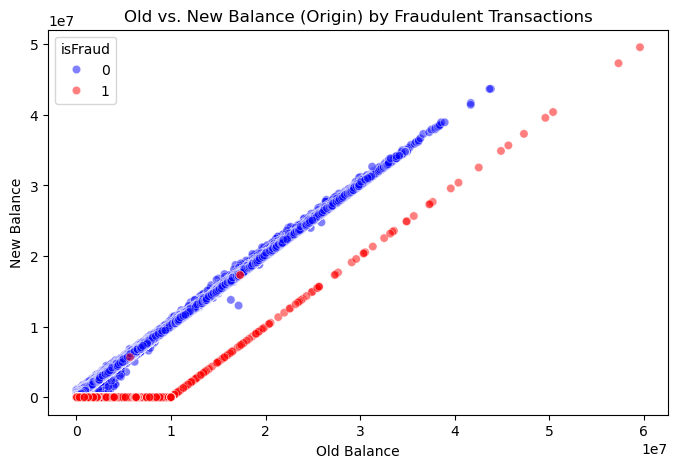

In [44]:
# Scatter plot for balance changes
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['oldbalanceOrg'], y=df['newbalanceOrig'], hue=df['isFraud'], palette=['blue', 'red'], alpha=0.5)
plt.title('Old vs. New Balance (Origin) by Fraudulent Transactions')
plt.xlabel('Old Balance')
plt.ylabel('New Balance')
plt.show()

#### Non-Fraudulent Transactions (Blue)
- Most follow a diagonal trend, where the new balance is close to the old balance. This suggests typical, legitimate transactions where users transfer only part of their funds.

#### Fraudulent Transactions (Red)
- Many fraudulent transactions show a pattern where the new balance is zero despite having a high old balance. This indicates that fraudsters often drain the entire account balance.

### Multivariate Analysis - Correlation Heatmap & 3D Scatter Plot

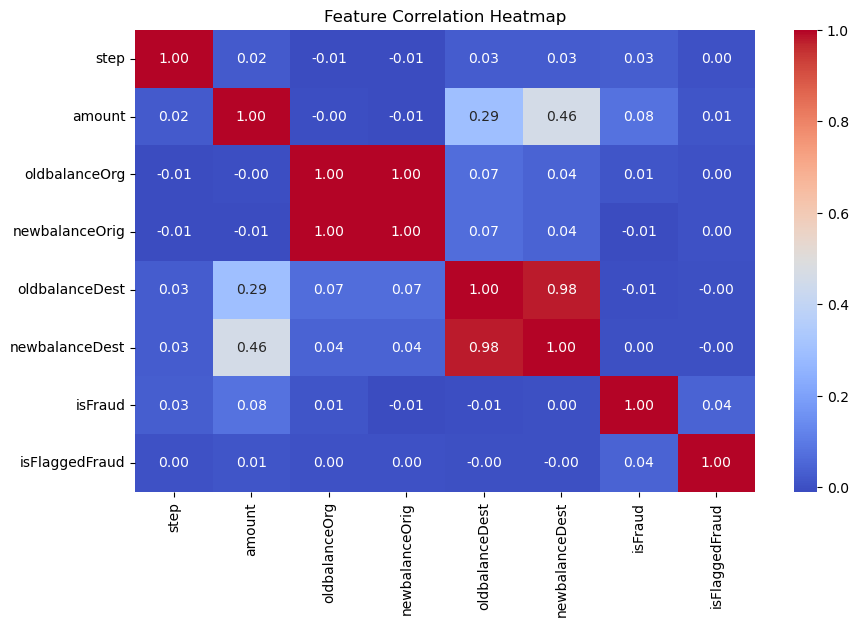

In [45]:
# Multivariate Analysis - Correlation Heatmap
numeric_data = df.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

- Old and new balances for both origin and destination accounts are almost perfectly correlated, meaning they move together.
- Transaction amount has a moderate correlation with new destination balances, which makes sense—larger transactions often result in higher destination balances.
- Fraud detection (isFraud) doesn’t show strong correlations with other features, meaning fraud isn’t directly tied to any single factor, making it harder to detect.
- Flagged fraud cases (isFlaggedFraud) have almost no correlation with actual fraud, suggesting the current flagging system may not be very effective.

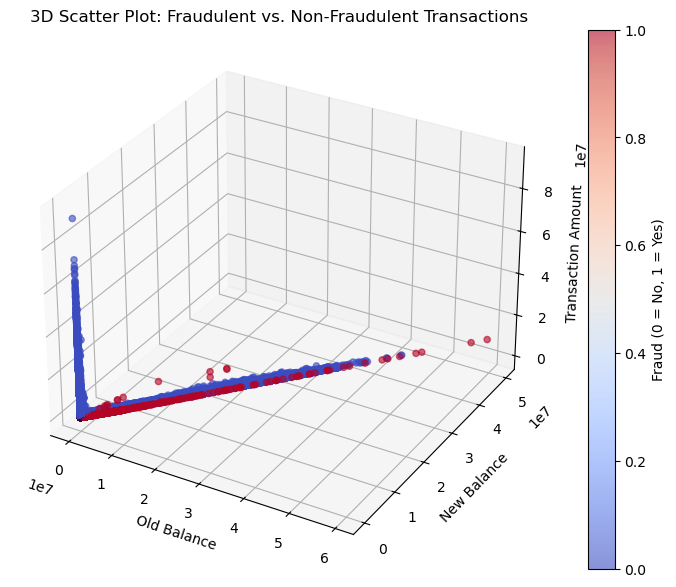

In [46]:
from mpl_toolkits.mplot3d import Axes3D

# Selecting three important features for the 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with fraud differentiation
sc = ax.scatter(df['oldbalanceOrg'], df['newbalanceOrig'], df['amount'], 
                c=df['isFraud'], cmap='coolwarm', alpha=0.6)

# Labels and title
ax.set_xlabel('Old Balance')
ax.set_ylabel('New Balance')
ax.set_zlabel('Transaction Amount')
ax.set_title('3D Scatter Plot: Fraudulent vs. Non-Fraudulent Transactions')

# Color bar for fraud classification
plt.colorbar(sc, label="Fraud (0 = No, 1 = Yes)")
plt.show()

- Legitimate transactions (blue) follow a diagonal pattern where the new balance is proportional to the old balance. This means that for non-fraudulent transactions, money is transferred as expected.
- Fraudulent transactions (red) deviate from this pattern, often showing a low new balance despite a high old balance. This suggests that fraudsters are draining accounts entirely.
- The color gradient (transaction amount) shows that fraud tends to occur across different transaction amounts, but often with larger sums.